<a href="https://colab.research.google.com/github/sunmingbai/AboutEnglishLearning/blob/main/MLcase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# pip install imbalanced-learn
# !pip install -U imbalanced-learn

In [ ]:
# !pip install -U xgboost

     |████████████████████████████████| 166.7MB 89kB/s 
  Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [1]:
import numpy  as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import warnings
warnings.simplefilter('ignore')

from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score,plot_confusion_matrix,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# from category_encoders import target_encoder
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from imblearn.under_sampling import TomekLinks 
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline 
from sklearn.base import BaseEstimator,TransformerMixin


# 修改路径名即可
newtrain=pd.read_csv('/content/drive/MyDrive/train_7w.csv').drop(columns=['REGION_RATING_CLIENT_W_CITY'])
newtest=pd.read_csv('/content/drive/MyDrive/test_2w.csv')

In [2]:
import xgboost
print("Scikit-Learn", xgboost.__version__)

Scikit-Learn 0.90


In [3]:
!pip install category_encoders

     |████████████████████████████████| 81kB 10.2MB/s 


In [4]:
from category_encoders import target_encoder

In [5]:
# 检查数据维度 需为61503*165 和24601*164
print('维度信息：',newtrain.shape,newtest.shape)

维度信息： (61503, 164) (24601, 164)


In [6]:
# 获取dummy后可保留的列名
app_train = pd.get_dummies(newtrain)
app_test = pd.get_dummies(newtest)

In [7]:
# train_target=app_train['TARGET']
# app_train = pd.get_dummies(newtrain)
# app_test = pd.get_dummies(newtest)
app_train,app_test=app_train.align(app_test,join='inner',axis=1)

In [7]:
# app_train = pd.get_dummies(newtrain)
# app_test = pd.get_dummies(newtest)
# app_train,app_test=app_train.align(app_test,join='inner',axis=1)
tarcol=[]
for col in app_train.columns:
    if col not in ['SK_ID_CURR','TARGET']:
      tarcol.append(col)


# 获取模型预测性能的函数
def getmetrics(y_true,y_pre):
    print('precison: ',precision_score(y_true,y_pre))
    print('recall: ',recall_score(y_true,y_pre))
    print('f1: ',f1_score(y_true,y_pre))
    print('accuracy: ',accuracy_score(y_true,y_pre))
    tn, fp, fn, tp = confusion_matrix(y_true, y_pre).ravel()
    cm=np.array([[tp,fp],[fn,tn]])
    sns.heatmap(cm,cmap='YlGnBu',annot=True,fmt='.20g')
    plt.xticks(ticks =[0.5,1.5] ,labels = np.array(['True_posi','True_nega']))
    plt.yticks(ticks =[0.5,1.5] ,labels = np.array(['Pre_posi','Pre_nega']))
#     plt.yticks(['预测正例','预测负例'])
    plt.show()
    

# get dummy for lr
class getdummy(BaseEstimator,TransformerMixin):
    def __init__(self,tarcol):
        self.tarcol=tarcol
        
    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        X_=pd.get_dummies(X)[self.tarcol]
        return X_

# 做pipeline 自动cv 输出结果的函数
def makepipe_getres(eastimators,set_param,cv_param,newtrain=newtrain,newtest=newtest,verbose=1,n_jobs=5,type_='Pipeline'):
    # verbose=1 show final metrics
    # =2 show best_params
    # =3 show cv_results_
    if type_=='Pipeline':
      initP=Pipeline(estimators)
    elif type_=='Stacking':
      initP=StackingClassifier(estimators=estimators, final_estimator=final_estimator)
    initP.set_params(**set_param)
    p_gs=GridSearchCV(initP,param_grid=cv_param,cv=5,verbose=3,n_jobs=n_jobs,scoring='f1',return_train_score=True)
    p_gs.fit(newtrain.drop(columns=['TARGET','SK_ID_CURR']),newtrain['TARGET'])
    if verbose>=3:
        print('cv_results:\n',p_gs.cv_results_)
        print('best_params:\n',p_gs.best_params_)
        
    elif verbose==2:
        print('best_params:\n',p_gs.best_params_)
    initP.set_params(**p_gs.best_params_)
    P=initP.fit(newtrain.drop(columns=['TARGET','SK_ID_CURR']),newtrain['TARGET'])
    pre=P.predict(newtest.drop(columns=['TARGET','SK_ID_CURR']))
    getmetrics(newtest['TARGET'],pre)
    
    return initP,P

SEED=42

In [8]:
from imblearn.ensemble import EasyEnsembleClassifier
from imblearn.ensemble import BalancedBaggingClassifier 
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import RUSBoostClassifier

In [ ]:
# rf_p={'max_depth': 12, 'n_estimators': 5}
estimators=[('targetencode',target_encoder.TargetEncoder()),('rus',RUSBoostClassifier(n_estimators = 20,random_state=42,base_estimator = LogisticRegression()))]
init_param=dict(targetencode__cols=newtrain.select_dtypes(include='object').columns)

pipe1=Pipeline(estimators)
pipe1.set_params(**init_param)

xgb_p={'max_depth': 5, 'n_estimators': 500}
estimators=[('targetencode',target_encoder.TargetEncoder()),('rus',RUSBoostClassifier(n_estimators = 20,random_state=42,base_estimator = XGBClassifier(**xgb_p)))]
init_param=dict(targetencode__cols=newtrain.select_dtypes(include='object').columns)

pipe2=Pipeline(estimators)
pipe2.set_params(**init_param)

init_param={
}

estimators = [
        ('rf',pipe1),
        ('xgb', pipe2)
 ]
final_estimator=LogisticRegression()
initP=StackingClassifier(estimators=estimators, final_estimator=final_estimator)
initP.fit(newtrain.drop(columns=['TARGET','SK_ID_CURR']),newtrain['TARGET'])
pre_prob=initP.predict_proba(newtest.drop(columns=['TARGET','SK_ID_CURR']))
pre=initP.predict(newtest.drop(columns=['TARGET','SK_ID_CURR']))

precison:  0.0
recall:  0.0
f1:  0.0
accuracy:  0.9205316857038331


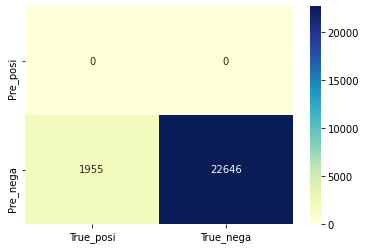

In [ ]:
getmetrics(newtest['TARGET'],pre)

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(newtest['TARGET'].values,pre_prob[:,1])

0.6047597030510516

precison:  0.0
recall:  0.0
f1:  0.0
accuracy:  0.9205316857038331


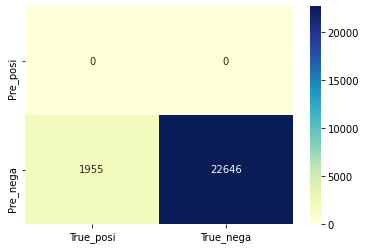

In [ ]:
getmetrics(newtest['TARGET'],pre)

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(newtest['TARGET'].values,pre_prob[:,1])

NameError: ignored

## develop base model

### lr已经在个人端跑完

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:   41.0s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:  3.6min finished


cv_results:
 {'mean_fit_time': array([ 3.4808764 ,  4.67648706,  7.14726806,  9.50448627, 14.29150901,
        4.01090989,  5.4843854 ,  8.63060489, 11.99307694, 17.93569427,
        4.38016167,  6.36919084, 10.09077387, 13.99851737, 21.67509465,
        4.65708337,  6.98499722, 11.65773702, 16.30243697, 24.42034445]), 'std_fit_time': array([0.13963068, 0.26988572, 0.08945418, 0.06961108, 0.15710766,
       0.07224623, 0.12831128, 0.12884563, 0.3347841 , 0.22717004,
       0.10745228, 0.17198196, 0.18012574, 0.1662754 , 0.25080094,
       0.09363573, 0.10015499, 0.14889713, 0.19846612, 0.76900682]), 'mean_score_time': array([0.24701152, 0.25958991, 0.30477457, 0.34087157, 0.40269699,
       0.24230156, 0.28395338, 0.30554876, 0.33974738, 0.42800097,
       0.24192977, 0.26912527, 0.30796509, 0.38281946, 0.46904426,
       0.23656554, 0.27225699, 0.33891802, 0.3862977 , 0.2653471 ]), 'std_score_time': array([0.01296396, 0.03358395, 0.03746703, 0.03130592, 0.00576654,
       0.03830338, 

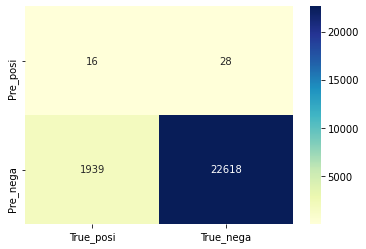

totally cost 221.64092874526978


In [ ]:
######################################################
# rf
import time
time_start=time.time()

estimators=[('targetencode',target_encoder.TargetEncoder()),('randomforest',RandomForestClassifier())]
init_param=dict(targetencode__cols=newtrain.select_dtypes(include='object').columns)
param_grid={
    'randomforest__n_estimators':[5,10,20,30,50],
    'randomforest__max_depth':[6,8,10,12]
}
initP_rf,P_rf=makepipe_getres(
    estimators,
    init_param,
    param_grid,
    verbose=3
)

time_end=time.time()
print('totally cost',time_end-time_start)

In [ ]:
# rf
# import time
# time_start=time.time()

estimators=[('targetencode',target_encoder.TargetEncoder()),('sm',SMOTE(random_state=SEED)),('randomforest',RandomForestClassifier())]
init_param=dict(targetencode__cols=newtrain.select_dtypes(include='object').columns,randomforest__max_depth= 12, randomforest__n_estimators= 5)
param_grid={
    'randomforest__max_depth':[6,7,8,9,10,11,12,13,14,15]
}

initP=Pipeline(estimators)
initP.set_params(**init_param)
p_gs=GridSearchCV(initP,param_grid=param_grid,cv=5,verbose=2,n_jobs=4,scoring='f1',return_train_score=True)
p_gs.fit(newtrain.drop(columns=['TARGET','SK_ID_CURR']),newtrain['TARGET'])


# time_end=time.time()
# print('totally cost',time_end-time_start)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:  2.3min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('targetencode',
                                        TargetEncoder(cols=Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE'],...
                                                               min_impurity_split=None,
                                                               min_samples_leaf=1,
                                                               min_samples_split=2,
                                                               min_weight_fraction_leaf=0.0,
                                                               n_estimators=5,
                                                               n_jobs=None,
                      

In [ ]:
p_gs.cv_results_

{'mean_fit_time': array([ 8.69678082,  9.19993339,  9.45498843,  9.87892799, 10.25416927,
        10.13207521, 10.46282592, 10.68096638, 10.87431717,  9.14665461]),
 'mean_score_time': array([0.18756852, 0.19140754, 0.19053817, 0.18934541, 0.1976274 ,
        0.2065052 , 0.18448496, 0.214468  , 0.21995883, 0.14343181]),
 'mean_test_score': array([0.18475397, 0.1808959 , 0.14972483, 0.14489795, 0.14902763,
        0.12180629, 0.14058166, 0.12410464, 0.11499386, 0.1102606 ]),
 'mean_train_score': array([0.20184639, 0.19333469, 0.19261748, 0.21154635, 0.23574491,
        0.2607217 , 0.32011083, 0.39491914, 0.44930639, 0.50762153]),
 'param_randomforest__max_depth': masked_array(data=[6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'params': [{'randomforest__max_depth': 6},
  {'randomforest__max_depth': 7},
  {'randomforest__max_depth': 8}

In [ ]:
test_score=p_gs.cv_results_['mean_test_score']

In [ ]:
train_score=p_gs.cv_results_['mean_train_score']

Text(0.5, 1.0, 'Random Forest (with SMOTE) Over-fitting')

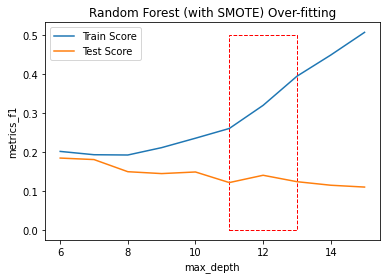

In [ ]:
plt.plot( [6, 7, 8, 9, 10, 11, 12, 13, 14, 15], train_score,label='Train Score')
plt.plot( [6, 7, 8, 9, 10, 11, 12, 13, 14, 15], test_score,label='Test Score')
plt.legend()
plt.xlabel('max_depth')
plt.ylabel('metrics_f1')

from matplotlib.patches import Rectangle

ax = plt.gca()

# Create a Rectangle patch
rect = Rectangle((11,0),2,0.5,linestyle='--',linewidth=1,edgecolor='r',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.title('Random Forest (with SMOTE) Over-fitting')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   15.1s remaining:   22.7s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   15.6s finished


cv_results:
 {'mean_fit_time': array([12.04263811]), 'std_fit_time': array([0.30163924]), 'mean_score_time': array([0.15278182]), 'std_score_time': array([0.08029172]), 'params': [{}], 'split0_test_score': array([0.12899543]), 'split1_test_score': array([0.1024911]), 'split2_test_score': array([0.10829335]), 'split3_test_score': array([0.102526]), 'split4_test_score': array([0.13207547]), 'mean_test_score': array([0.11487627]), 'std_test_score': array([0.01299553]), 'rank_test_score': array([1], dtype=int32)}
best_params:
 {}
precison:  0.16914749661705006
recall:  0.0639386189258312
f1:  0.09279881217520415
accuracy:  0.9006544449412626


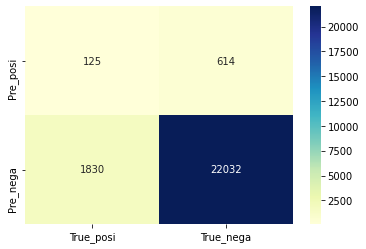

totally cost 24.337160348892212


In [ ]:
######################################################
# rf
import time
time_start=time.time()

estimators=[('targetencode',target_encoder.TargetEncoder()),('sm',SMOTE(random_state=SEED)),('randomforest',RandomForestClassifier())]
init_param=dict(targetencode__cols=newtrain.select_dtypes(include='object').columns,randomforest__max_depth= 12, randomforest__n_estimators= 5)
param_grid={
}
initP_rf_smote,P_rf_smote=makepipe_getres(
    estimators,
    init_param,
    param_grid,
    verbose=3
)

time_end=time.time()
print('totally cost',time_end-time_start)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  1.6min remaining:  2.4min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  1.7min finished


cv_results:
 {'mean_fit_time': array([91.46684003]), 'std_fit_time': array([4.83654816]), 'mean_score_time': array([0.12982244]), 'std_score_time': array([0.05019456]), 'params': [{}], 'split0_test_score': array([0.03100775]), 'split1_test_score': array([0.01576355]), 'split2_test_score': array([0.02167488]), 'split3_test_score': array([0.01373896]), 'split4_test_score': array([0.00994036]), 'mean_test_score': array([0.0184251]), 'std_test_score': array([0.00734736]), 'rank_test_score': array([1], dtype=int32)}
best_params:
 {}
precison:  0.4
recall:  0.008184143222506393
f1:  0.016040100250626566
accuracy:  0.9202064956709077


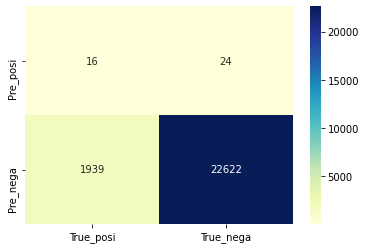

totally cost 164.0273494720459


In [ ]:
######################################################
# rf
import time
time_start=time.time()

estimators=[('targetencode',target_encoder.TargetEncoder()),('tl',TomekLinks()),('randomforest',RandomForestClassifier())]
init_param=dict(targetencode__cols=newtrain.select_dtypes(include='object').columns,randomforest__max_depth= 12, randomforest__n_estimators= 5)
param_grid={
}
initP_rf_tl,P_rf_tl=makepipe_getres(
    estimators,
    init_param,
    param_grid,
    verbose=3
)

time_end=time.time()
print('totally cost',time_end-time_start)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  3.3min remaining:  5.0min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  3.5min finished


cv_results:
 {'mean_fit_time': array([197.99627914]), 'std_fit_time': array([7.51578288]), 'mean_score_time': array([0.15472531]), 'std_score_time': array([0.06513952]), 'params': [{}], 'split0_test_score': array([0.20562029]), 'split1_test_score': array([0.21056911]), 'split2_test_score': array([0.18759019]), 'split3_test_score': array([0.2006689]), 'split4_test_score': array([0.17540767]), 'mean_test_score': array([0.19597123]), 'std_test_score': array([0.01281696]), 'rank_test_score': array([1], dtype=int32)}
best_params:
 {}
precison:  0.16015846066779854
recall:  0.2895140664961637
f1:  0.20623064310439063
accuracy:  0.8228933783179545


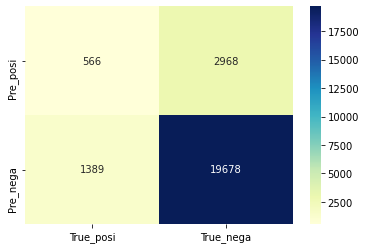

totally cost 363.6827759742737


In [ ]:
######################################################
# rf
import time
time_start=time.time()

estimators=[('targetencode',target_encoder.TargetEncoder()),('smenn',SMOTEENN(random_state=SEED)),('randomforest',RandomForestClassifier())]
init_param=dict(targetencode__cols=newtrain.select_dtypes(include='object').columns,randomforest__max_depth= 12, randomforest__n_estimators= 5)
param_grid={
}
initP_rf_se,P_rf_se=makepipe_getres(
    estimators,
    init_param,
    param_grid,
    verbose=3
)

time_end=time.time()
print('totally cost',time_end-time_start)

In [ ]:
## xgb

import time
time_start=time.time()

estimators=[('targetencode',target_encoder.TargetEncoder()),('xgb',XGBClassifier())]
init_param=dict(targetencode__cols=newtrain.select_dtypes(include='object').columns,xgb__tree_method='gpu_hist',xgb__n_jobs=4)
param_grid={
    'xgb__n_estimators':[20,100,200,300,500],
    'xgb__max_depth':[5,9,11]
}
initP_xgb,P_xgb=makepipe_getres(
    estimators,
    init_param,
    param_grid,
    verbose=2
)

time_end=time.time()
print('totally cost',time_end-time_start)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


KeyboardInterrupt: ignored

In [ ]:

## xgb

import time
time_start=time.time()

estimators=[('targetencode',target_encoder.TargetEncoder()),('tl',SMOTEENN()),('xgb',XGBClassifier())]
init_param=dict(targetencode__cols=newtrain.select_dtypes(include='object').columns,xgb__tree_method='gpu_hist',xgb__n_jobs=4)
param_grid={
    'xgb__n_estimators':[500],
    'xgb__max_depth':[5]
}
initP_xgb_tl,P_xgb_tl=makepipe_getres(
    estimators,
    init_param,
    param_grid,
    verbose=2
)

time_end=time.time()
print('totally cost',time_end-time_start)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   10.5s remaining:   15.8s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   14.9s finished


KeyError: ignored

In [ ]:
newtest['NAME_CONTRACT_TYPE']

0             Cash loans
1             Cash loans
2             Cash loans
3             Cash loans
4        Revolving loans
              ...       
24596    Revolving loans
24597         Cash loans
24598         Cash loans
24599    Revolving loans
24600         Cash loans
Name: NAME_CONTRACT_TYPE, Length: 24601, dtype: object

In [ ]:
'NAME_CONTRACT_TYPE' in newtrain.select_dtypes(include='object').columns

True

In [ ]:
estimators=[('targetencode',target_encoder.TargetEncoder()),('sm',SMOTE(random_state=SEED)),('randomforest',RandomForestClassifier())]
init_param=dict(targetencode__cols=newtrain.select_dtypes(include='object').columns,randomforest__max_depth= 12, randomforest__n_estimators= 5)
P_rf_sm=Pipeline(estimators)
P_rf_sm.set_params(**init_param)

Pipeline(memory=None,
         steps=[('targetencode',
                 TargetEncoder(cols=Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE'],
      dtype='object'),
                               drop_invariant=False, handle_...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=12, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                               

In [ ]:
# estimators=[('targetencode',target_encoder.TargetEncoder()),('sm',SMOTE(random_state=SEED)),('randomforest',RandomForestClassifier())]
# init_param=dict(targetencode__cols=newtrain.select_dtypes(include='object').columns,randomforest__max_depth= 12, randomforest__n_estimators= 5)
# P_rf_sm=Pipeline(estimators)
# P_rf_sm.set_params(**init_param)

# estimators=[('targetencode',target_encoder.TargetEncoder()),('sm',SMOTE(random_state=SEED)),('xgb',XGBClassifier())]
# init_param=dict(targetencode__cols=newtrain.select_dtypes(include='object').columns,xgb__tree_method='gpu_hist',xgb__max_depth= 5, xgb__n_estimators= 500)
# P_xgb_sm=Pipeline(estimators)
# P_xgb_sm.set_params(**init_param)

# init_param={
#     'final_estimator__C': 0.5
# }

# estimators = [
#         ('rf', P_rf_sm),
#         ('xgb', P_xgb_sm)
#  ]
# final_estimator=LogisticRegression()

# param_grid={
# }

# import time
# time_start=time.time()

# initP_stack,P_stack=makepipe_getres(
#     estimators,
#     init_param,
#     param_grid,
#     type_='Stacking',
#     verbose=2
# )

# time_end=time.time()
# print('totally cost',time_end-time_start)

In [ ]:
estimators=[('targetencode',target_encoder.TargetEncoder()),('sm',SMOTE(random_state=SEED)),('xgb',XGBClassifier())]
init_param=dict(targetencode__cols=newtrain.select_dtypes(include='object').columns,xgb__tree_method='gpu_hist',xgb__max_depth= 5, xgb__n_estimators= 500)
P_xgb_sm=Pipeline(estimators)
P_xgb_sm.set_params(**init_param)

Pipeline(memory=None,
         steps=[('targetencode',
                 TargetEncoder(cols=Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE'],
      dtype='object'),
                               drop_invariant=False, handle_...
                               max_delta_step=None, max_depth=5,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=500,
                               n_jobs=None, num_parallel_tree=None,
                               objective='binary:logistic', random_state=None,
                               reg_alpha=None, reg_lambda=None,
                               scale_pos_weight=None, subsample=None,
                               tree_method='gpu_hist', us

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  4.4min remaining:  6.6min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  4.6min finished


[08:16:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:16:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:16:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:16:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

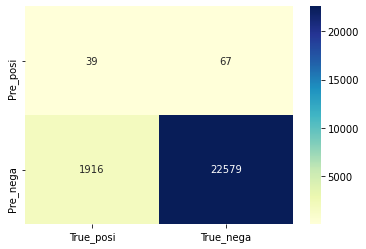

totally cost 417.09243392944336


In [ ]:
init_param={
    'final_estimator__C': 0.5
}

estimators = [
        ('rf', P_rf_sm),
        ('xgb', P_xgb_sm)
 ]
final_estimator=LogisticRegression()

param_grid={
}

import time
time_start=time.time()

initP_stack,P_stack=makepipe_getres(
    estimators,
    init_param,
    param_grid,
    type_='Stacking',
    verbose=2
)

time_end=time.time()
print('totally cost',time_end-time_start)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed: 15.5min remaining: 23.2min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed: 16.5min finished


[08:42:13] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:44:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:45:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:45:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

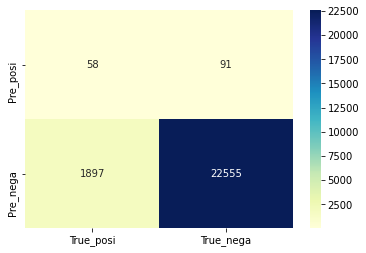

totally cost 1644.4758560657501


In [ ]:
estimators=[('targetencode',target_encoder.TargetEncoder()),('tl',TomekLinks()),('randomforest',RandomForestClassifier())]
init_param=dict(targetencode__cols=newtrain.select_dtypes(include='object').columns,randomforest__max_depth= 12, randomforest__n_estimators= 5)
P_rf_tl=Pipeline(estimators)
P_rf_tl.set_params(**init_param)

estimators=[('targetencode',target_encoder.TargetEncoder()),('tl',TomekLinks()),('xgb',XGBClassifier())]
init_param=dict(targetencode__cols=newtrain.select_dtypes(include='object').columns,xgb__tree_method='gpu_hist',xgb__max_depth= 5, xgb__n_estimators= 500)
P_xgb_tl=Pipeline(estimators)
P_xgb_tl.set_params(**init_param)

init_param={
    'final_estimator__C': 0.5
}

estimators = [
        ('rf', P_rf_tl),
        ('xgb', P_xgb_tl)
 ]
final_estimator=LogisticRegression()

param_grid={
}

import time
time_start=time.time()

initP_stack,P_stack=makepipe_getres(
    estimators,
    init_param,
    param_grid,
    type_='Stacking',
    verbose=3
)

time_end=time.time()
print('totally cost',time_end-time_start)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed: 33.8min remaining: 50.7min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed: 36.6min finished


[09:35:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:40:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:41:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:42:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

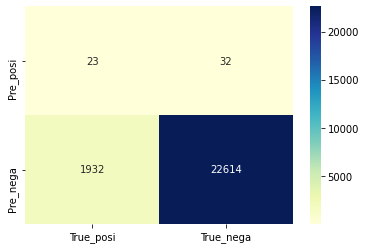

totally cost 3627.892143011093


In [ ]:
estimators=[('targetencode',target_encoder.TargetEncoder()),('se',SMOTEENN(random_state=SEED)),('randomforest',RandomForestClassifier())]
init_param=dict(targetencode__cols=newtrain.select_dtypes(include='object').columns,randomforest__max_depth= 12, randomforest__n_estimators= 5)
P_rf_se=Pipeline(estimators)
P_rf_se.set_params(**init_param)

estimators=[('targetencode',target_encoder.TargetEncoder()),('se',SMOTEENN(random_state=SEED)),('xgb',XGBClassifier())]
init_param=dict(targetencode__cols=newtrain.select_dtypes(include='object').columns,xgb__tree_method='gpu_hist',xgb__max_depth= 5, xgb__n_estimators= 500)
P_xgb_se=Pipeline(estimators)
P_xgb_se.set_params(**init_param)

init_param={
    'final_estimator__C': 0.5
}

estimators = [
        ('rf', P_rf_se),
        ('xgb', P_xgb_se)
 ]
final_estimator=LogisticRegression()

param_grid={
}

import time
time_start=time.time()

initP_stack,P_stack=makepipe_getres(
    estimators,
    init_param,
    param_grid,
    type_='Stacking',
    verbose=3
)

time_end=time.time()
print('totally cost',time_end-time_start)

In [ ]:
# 
## xgb

import time
time_start=time.time()

estimators=[('targetencode',target_encoder.TargetEncoder()),('sm',SMOTE(random_state=SEED)),('xgb',XGBClassifier())]
init_param=dict(targetencode__cols=newtrain.select_dtypes(include='object').columns,xgb__n_jobs=4)
param_grid={
    'xgb__n_estimators':[500],
    'xgb__max_depth':[5]
}
initP_xgb_smote,P_xgb_smote=makepipe_getres(
    estimators,
    init_param,
    param_grid,
    verbose=2,
    n_jobs=4
)

time_end=time.time()
print('totally cost',time_end-time_start)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   34.6s remaining:   51.8s


ValueError: ignored

## smote stacking

In [ ]:
init_param={}

estimators = [
        ('rf', P_rf_smote),
        ('xgb', P_xgb_smote)
 ]
final_estimator=LogisticRegression()

param_grid={
}

import time
time_start=time.time()

initP_stack,P_stack=makepipe_getres(
    estimators,
    init_param,
    param_grid,
    type_='Stacking',
    verbose=2
)

time_end=time.time()
print('totally cost',time_end-time_start)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  12 out of  15 | elapsed:  8.3min remaining:  2.1min
[Parallel(n_jobs=5)]: Done  15 out of  15 | elapsed:  8.4min finished


best_params:
 {'final_estimator__C': 0.5}
precison:  0.42162162162162165
recall:  0.03989769820971867
f1:  0.07289719626168224
accuracy:  0.9193528718344782


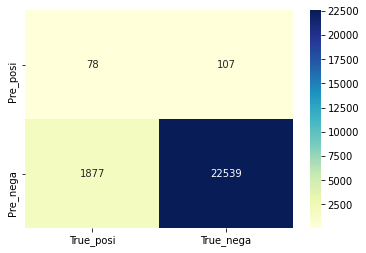

totally cost 581.4994430541992


In [ ]:
init_param={}

estimators = [
        ('rf', P_rf),
        ('xgb', P_xgb)
 ]
final_estimator=LogisticRegression()

param_grid={
    'final_estimator__C':[0.1,0.2,0.5]
}

import time
time_start=time.time()

initP_stack,P_stack=makepipe_getres(
    estimators,
    init_param,
    param_grid,
    type_='Stacking',
    verbose=2
)

time_end=time.time()
print('totally cost',time_end-time_start)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  12 out of  15 | elapsed:  1.2min remaining:   18.6s
[Parallel(n_jobs=5)]: Done  15 out of  15 | elapsed:  1.3min finished


best_params:
 {'xgb__max_depth': 5, 'xgb__n_estimators': 500, 'xgb__scale_pos_weight': 10}
precison:  0.19552071668533036
recall:  0.4465473145780051
f1:  0.27196261682242995
accuracy:  0.810007723263282


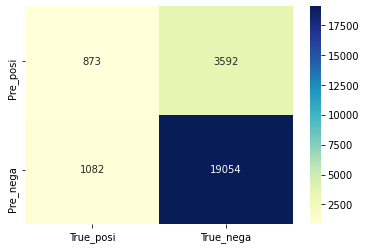

totally cost 91.54282355308533


In [ ]:
#######################################################
# xgb
import time
time_start=time.time()

estimators=[('targetencode',target_encoder.TargetEncoder()),('xgb',XGBClassifier())]
init_param=dict(targetencode__cols=newtrain.select_dtypes(include='object').columns,xgb__tree_method='gpu_hist',xgb__n_jobs=5)
param_grid={
    'xgb__n_estimators':[500],
    'xgb__max_depth':[5],
    'xgb__scale_pos_weight':[1,7,10]
}
initP_xgb_weight,P_xgb_weight=makepipe_getres(
    estimators,
    init_param,
    param_grid,
    verbose=2
)

time_end=time.time()
print('totally cost',time_end-time_start)

In [ ]:
# ##################################################
# # lr
# import time
# time_start=time.time()

# estimators=(('getdummy',getdummy(tarcol)),('lr',LogisticRegression()))
# init_param=dict()
# param_grid={
    # 'lr__C':[0.1,0.2,0.5],
    # 'lr__class_weight':[{0:1.0, 1:8.0},{0:1.0, 1:10.0}]
# }
# initP_lr,P_lr=makepipe_getres(
#     estimators,
#     init_param,
#     param_grid,
#     verbose=3
# )

# time_end=time.time()
# print('totally cost',time_end-time_start)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  12 out of  15 | elapsed:   15.1s remaining:    3.8s
[Parallel(n_jobs=5)]: Done  15 out of  15 | elapsed:   15.2s finished


cv_results:
 {'mean_fit_time': array([4.60315309, 4.59590039, 4.41633034]), 'std_fit_time': array([0.11674517, 0.08356312, 0.09977868]), 'mean_score_time': array([0.26800985, 0.26406446, 0.17842197]), 'std_score_time': array([0.03611713, 0.03618419, 0.04077015]), 'param_randomforest__class_weight': masked_array(data=[{0: 1.0, 1: 1.0}, {0: 1.0, 1: 7.0}, {0: 1.0, 1: 10.0}],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'param_randomforest__max_depth': masked_array(data=[12, 12, 12],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'param_randomforest__n_estimators': masked_array(data=[5, 5, 5],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'randomforest__class_weight': {0: 1.0, 1: 1.0}, 'randomforest__max_depth': 12, 'randomforest__n_estimators': 5}, {'randomforest__class_weight': {0: 1.0, 1: 7.0}, 'randomforest__max_depth': 12, 'randomforest__n_

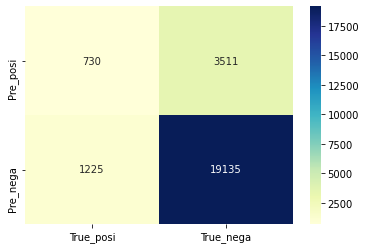

totally cost 18.543840646743774


In [ ]:
######################################################
# rf
import time
time_start=time.time()

estimators=[('targetencode',target_encoder.TargetEncoder()),('randomforest',RandomForestClassifier())]
init_param=dict(targetencode__cols=newtrain.select_dtypes(include='object').columns)
param_grid={
    'randomforest__n_estimators':[5],
    'randomforest__max_depth':[12],
    'randomforest__class_weight':[{0:1.0, 1:1.0},{0:1.0, 1:7.0},{0:1.0, 1:10.0}]
}
initP_rf_weight,P_rf_weight=makepipe_getres(
    estimators,
    init_param,
    param_grid,
    verbose=3
)

time_end=time.time()
print('totally cost',time_end-time_start)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed: 15.4min finished


best_params:
 {'final_estimator__C': 0.2, 'final_estimator__class_weight': {0: 1.0, 1: 8.0}}
precison:  0.1765005951368815
recall:  0.5309462915601023
f1:  0.2649310872894334
accuracy:  0.7658631762936466


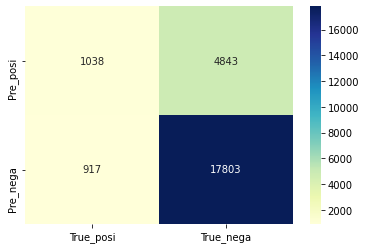

totally cost 1001.773298740387


In [ ]:
init_param={}

estimators = [
        ('rf', P_rf_weight),
        ('xgb', P_xgb_weight)
 ]
final_estimator=LogisticRegression()

param_grid={
    'final_estimator__C':[0.1,0.2,0.5],
    'final_estimator__class_weight':[{0:1.0,1:1.0},{0:1.0,1:8.0}]
}

import time
time_start=time.time()

initP_stack,P_stack=makepipe_getres(
    estimators,
    init_param,
    param_grid,
    type_='Stacking',
    verbose=2
)

time_end=time.time()
print('totally cost',time_end-time_start)

In [ ]:
lr_param={
        'lr__C':[0.001,0.1,0.5],
        'lr__class_weight':[{0:1.0, 1:1.0},{0:1.0, 1:7.0},{0:1.0, 1:10.0}]
}

In [ ]:
rf_estimators=[('targetencode',target_encoder.TargetEncoder(cols=newtrain.select_dtypes(include='object').columns)),('randomforest',RandomForestClassifier())]
xgb_estimators=[('targetencode',target_encoder.TargetEncoder(cols=newtrain.select_dtypes(include='object').columns)),('xgb',XGBClassifier(tree_method='gpu_hist',n_jobs=5))]

init_param={}

estimators = [
        ('rf', Pipeline(rf_estimators)),
        ('xgb', Pipeline(xgb_estimators))
 ]
final_estimator=LogisticRegression()

In [ ]:
param_grid={
    'rf__randomforest__n_estimators':[30,50],
    'rf__randomforest__max_depth':[7,10],
    'rf__randomforest__class_weight':[{0:1.0,1:10.0}],
    'xgb__xgb__n_estimators':[70,100],
    'xgb__xgb__max_depth':[5,9],
    'xgb__xgb__scale_pos_weight':[7],
    'final_estimator__C':[0.1,0.2,0.5],
    'final_estimator__class_weight':[{0:1.0,1:1.0},{0:1.0,1:8.0}]
}

In [ ]:
# clf=StackingClassifier(estimators=estimators, final_estimator=final_estimator)

In [ ]:
import time
time_start=time.time()

initP_stack,P_stack=makepipe_getres(
    estimators,
    init_param,
    param_grid,
    type_='Stacking',
    verbose=2
)

time_end=time.time()
print('totally cost',time_end-time_start)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


In [ ]:
 # import time
# time_start=time.time()

# initP_stack,P_stack=makepipe_getres(
#     estimators,
#     init_param,
#     param_grid,
#     type_='Stacking',
#     verbose=2
# )

# time_end=time.time()
# print('totally cost',time_end-time_start)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:  2.2min
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed: 11.7min
[Parallel(n_jobs=5)]: Done 278 tasks      | elapsed: 28.0min
[Parallel(n_jobs=5)]: Done 300 out of 300 | elapsed: 30.8min finished


best_params:
 {'randomforest__class_weight': {0: 1.0, 1: 7.0}, 'randomforest__max_depth': 12, 'randomforest__n_estimators': 50}
precison:  0.11623315306034852
recall:  0.6925831202046036
f1:  0.19905910026462803
accuracy:  0.5570911751554815


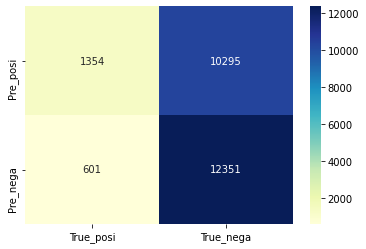

totally cost 1899.3109030723572


In [ ]:
######################################################
# rf
import time
time_start=time.time()

estimators=[('targetencode',target_encoder.TargetEncoder()),('smote',SMOTE(random_state=SEED)),('randomforest',RandomForestClassifier())]
init_param=dict(targetencode__cols=newtrain.select_dtypes(include='object').columns)
param_grid={
    'randomforest__n_estimators':[5,10,20,30,50],
    'randomforest__max_depth':[6,8,10,12],
    'randomforest__class_weight':[{0:1.0, 1:1.0},{0:1.0, 1:7.0},{0:1.0, 1:10.0}]
}
initP_rf_sm,P_rf_sm=makepipe_getres(
    estimators,
    init_param,
    param_grid,
    verbose=2
)

time_end=time.time()
print('totally cost',time_end-time_start)

In [ ]:
######################################################
# rf-enn
import time
time_start=time.time()

estimators=[('targetencode',target_encoder.TargetEncoder()),('smote_enn',SMOTEENN(random_state=SEED)),('randomforest',RandomForestClassifier())]
init_param=dict(targetencode__cols=newtrain.select_dtypes(include='object').columns)
param_grid={
    'randomforest__n_estimators':[5,10,20,30,50],
    'randomforest__max_depth':[6,8,10,12],
    'randomforest__class_weight':[{0:1.0, 1:1.0},{0:1.0, 1:7.0},{0:1.0, 1:10.0}]
}
initP_rf_enn,P_rf_enn=makepipe_getres(
    estimators,
    init_param,
    param_grid,
    verbose=2
)

time_end=time.time()
print('totally cost',time_end-time_start)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed: 21.0min
